# Image registration with nipy

Nipy has some flexible routines for image registration.  You can choose many parameters such as cost function for matching the images, interpolation method for resampling the images during registration, and optimation method.

In [1]:
import numpy as np

In [2]:
# - make numpy print numbers to 4dp only
np.set_printoptions(precision=4, suppress=True)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

Here we do a registration rather like the default coregistration routine with SPM.

In [4]:
import nipy
import nipy.core.api as nica
from nipy.algorithms.registration import HistogramRegistration, resample

First we make a new 3D image by taking the mean of all voxels across time in the 4D image.  We drop the first four volumes because of the T1 effect (see the diagnostics notebook):

In [5]:
img = nipy.load_image('ds114_sub009_t2r1.nii')
mean_data = img.get_data()[..., 4:].mean(axis=-1)
# Drop the time dimension from the coordinate map
coordmap_3d = nica.drop_io_dim(img.coordmap, 't')
mean_img = nica.Image(mean_data, coordmap_3d)

The "source" image is the image we are going to move to match the "target" image.  Here we are moving the structural image to match the mean functional image:

In [6]:
source = nipy.load_image('ds114_sub009_highres_brain.nii')
target = mean_img

In [7]:
source.coordmap

AffineTransform(
   function_domain=CoordinateSystem(coord_names=('i', 'j', 'k'), name='voxels', coord_dtype=float64),
   function_range=CoordinateSystem(coord_names=('scanner-x=L->R', 'scanner-y=P->A', 'scanner-z=I->S'), name='scanner', coord_dtype=float64),
   affine=array([[  -1.    ,    0.    ,    0.    ,  122.7012],
                 [   0.    ,    1.3002,   -0.    ,  -86.6199],
                 [  -0.    ,    0.    ,    1.    , -173.3327],
                 [   0.    ,    0.    ,    0.    ,    1.    ]])
)

These images are actually fairly well matched before registration, because they were taken from the same scanning session, and the subject didn't move much between the functional and structural scan.

The affine array for each image records the positions of the voxels relative to the center of the scanner.

The affines show us the correspondence of the voxels, even though the images have different fields of view and voxel sizes.   To show this we can use `resample` to resample the structural image to the same array grid as the functional image.  The `resample` command works out which voxel value to put in the empty voxel grid by using the affine and then resampling from the structural image array:

In [8]:
# Resample structural to functional without transform
source_before = resample(source, np.eye(4), reference=target)

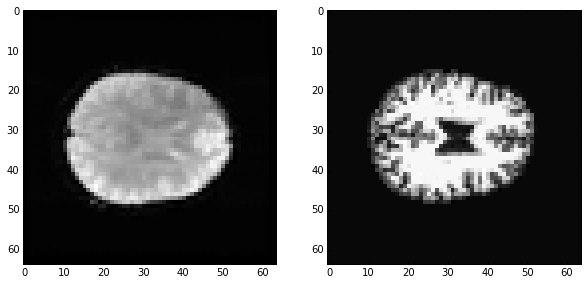

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(target.get_data()[:, :, 15])
axes[1].imshow(source_before.get_data()[:, :, 15])

To show nipy in action, we first disturb the registration to give the algorithm something to do.

This shift is just in the affine matrix, because the affine matrices record the current positions of the structural and functional image, relative to each other, and the world space of the scanner:

In [10]:
# Move structural 10 mm to the left relative to the functional (mean)
source.affine[0, -1] += 10
source_before = resample(source, np.eye(4), reference=target)

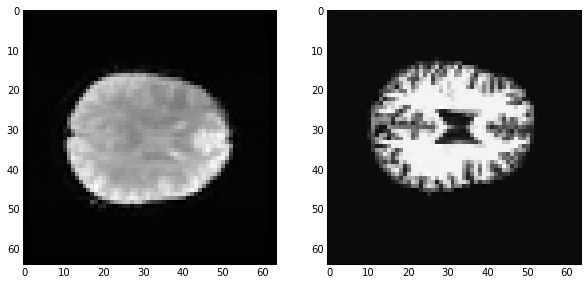

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(target.get_data()[:, :, 15])
axes[1].imshow(source_before.get_data()[:, :, 15])

We set up the registration in nipy, choosing our image similarity metric (in this case Normalize Mutual Information), the interpolation to use when generating a new image at each step of the registration (Random perturbation of the voxel coordinates), and using the optimization method Powell:

In [12]:
registration = HistogramRegistration(source, target, similarity='nmi', interp='rand')
transform = registration.optimize('rigid', optimizer='powell')

Initial guess...
translation : [ 0.  0.  0.]
rotation    : [ 0.  0.  0.]

Optimizing using fmin_powell
translation : [-13.0562   1.       6.4179]
rotation    : [-0.0026 -0.0001 -0.0062]

nmi = 0.267171289077

translation : [-12.6742   2.       6.4392]
rotation    : [-0.0021  0.0099  0.0038]

nmi = 0.2681862398

Optimization terminated successfully.
         Current function value: -0.268246
         Iterations: 2
         Function evaluations: 83


This results in an estimated affine that goes from world (scanner, millimeter) coordinates in the source images, to world coordinates in the target image:

In [13]:
transform.as_affine()

array([[  0.9999,  -0.0038,   0.0099, -12.6742],
       [  0.0038,   1.    ,   0.0021,   2.    ],
       [ -0.0099,  -0.002 ,   0.9999,   6.4392],
       [  0.    ,   0.    ,   0.    ,   1.    ]])

As ever you can inspect the registration object by using `?` to get help and doing tab completion in IPython:

In [14]:
# HistogramRegistration?

We make a new resampled copy of the structural image, at the same voxel grid as the structural.  It's nearer to its original position now:

In [15]:
source_after = resample(source, transform.inv(), reference=target)

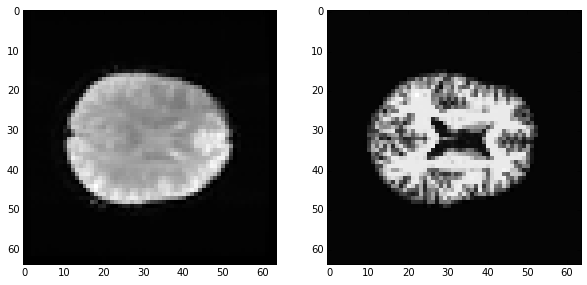

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(target.get_data()[:, :, 15])
axes[1].imshow(source_after.get_data()[:, :, 15])